# 02 - Modeling

This notebook builds predictive models for Alzheimer's diagnosis using the significant brain volume and severity index variables identified in the EDA notebook (01_EDA_relationships).


In [1]:
import sys
from pathlib import Path

project_root = Path(__file__).parent.parent if "__file__" in globals() else Path("..").resolve()
sys.path.append(str(project_root))

import pandas as pd
import matplotlib.pyplot as plt
import os

from src.modeling import fit_linear_regression, fit_random_forest, compare_models
from src.visualization import plot_regression_results, plot_feature_importance
from src.config import severity_cols, brain_cols


In [2]:
# Path
project_root = Path(__file__).parent.parent if "__file__" in globals() else Path("..").resolve()

tables_dir = project_root / "reports" / "tables"
figures_dir = project_root / "reports" / "figures"


In [3]:
# Load  processed dataset
DATA_PATH = Path("../data/processed/nacc_alzheimers_dataset_processed.csv")
df = pd.read_csv(DATA_PATH)

print("Processed dataset loaded. Shape:", df.shape)


Processed dataset loaded. Shape: (2700, 57)


In [4]:
# Load variables selected via Chi-square
significant_brain_volumes = pd.read_csv(tables_dir / "chi_square_significant_brain_volumes.csv")["variable"].tolist()
print("Significant brain volumes:", significant_brain_volumes)

significant_severity_indices = pd.read_csv(tables_dir / "chi_square_significant_severity_indices.csv")["variable"].tolist()
print("Significant severity indices:", significant_severity_indices)


Significant brain volumes: ['lhippo', 'rhippo', 'lent', 'rent', 'lparhip', 'rparhip']
Significant severity indices: ['delsev', 'hallsev', 'agitsev', 'depdsev', 'anxsev', 'elatsev', 'apasev', 'disnsev', 'irrsev', 'motsev', 'nitesev', 'appsev']


## Lineal Regression Predicctions

In [5]:
lr_results = []

for sev in significant_severity_indices:
    out = fit_linear_regression(
        df=df,
        feature_columns=significant_brain_volumes,
        target_column=sev
    )

    lr_results.append({
        "severity_index": sev,
        "r2": out["r2"],
        "results_df": out["results_df"],
        "coefficients": out["coefficients"]
    })


In [6]:
# Save
for res in lr_results:
    sev = res["severity_index"]

    # Save predictions
    res["results_df"].to_csv(
        os.path.join(tables_dir, f"lr_predictions_{sev}.csv"),
        index=False
    )

    # Save plots
    save_path = os.path.join(figures_dir, f"lr_regression_{sev}.png") 
    plot_regression_results( 
        res["results_df"], 
        target_column=sev, 
        save_path=save_path, 
        show=False 
    )


anxsev — R²: -0.032


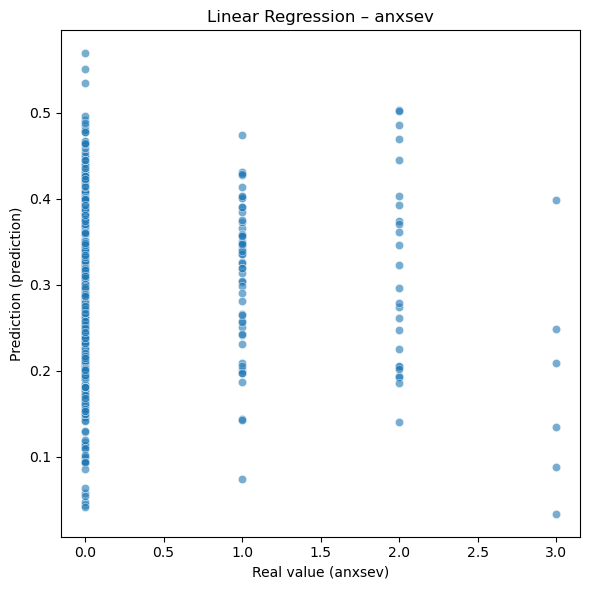

apasev — R²: 0.024


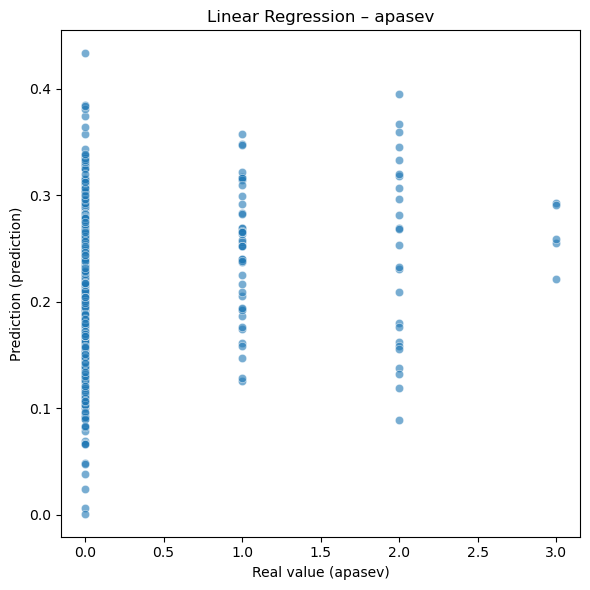

hallsev — R²: -0.020


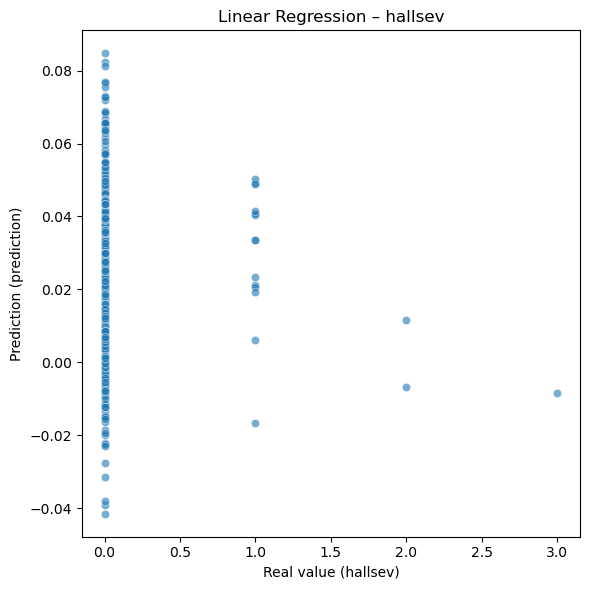

In [7]:
# Top 3 predictions
top_3_lr = (
    sorted(lr_results, key=lambda x: abs(x["r2"]), reverse=True)
    [:3]
)

for res in top_3_lr:
    sev = res["severity_index"]
    r2 = res["r2"]

    print(f"{sev} — R²: {r2:.3f}")

    plot_regression_results(
        res["results_df"],
        target_column=sev
    )


## Random Forest Predicctions

In [8]:
rf_results = []

for sev in significant_severity_indices:
    out = fit_random_forest(
        df=df,
        feature_columns=significant_brain_volumes,
        target_column=sev,
        n_estimators=100,
        max_depth=10
    )

    rf_results.append({
        "severity_index": sev,
        "r2": out["r2"],
        "results_df": out["results_df"],
        "feature_importances": out["feature_importances"]
    })


In [9]:
# Save
for res in rf_results:
    sev = res["severity_index"]

    # Save predictions
    res["results_df"].to_csv(
        os.path.join(tables_dir, f"rf_predictions_{sev}.csv"),
        index=False
    )

    # Save feature importances table
    res["feature_importances"].to_csv(
        os.path.join(tables_dir, f"rf_feature_importances_{sev}.csv"),
        index=False
    )

    # Save feature importance plots
    save_path = os.path.join(figures_dir, f"rf_feature_importance_{sev}.png")
    plot_feature_importance(
        res["feature_importances"],
        target=sev,
        model_name="Random Forest",
        save_path=save_path, 
        show=False
    )


elatsev — R²: -0.1225


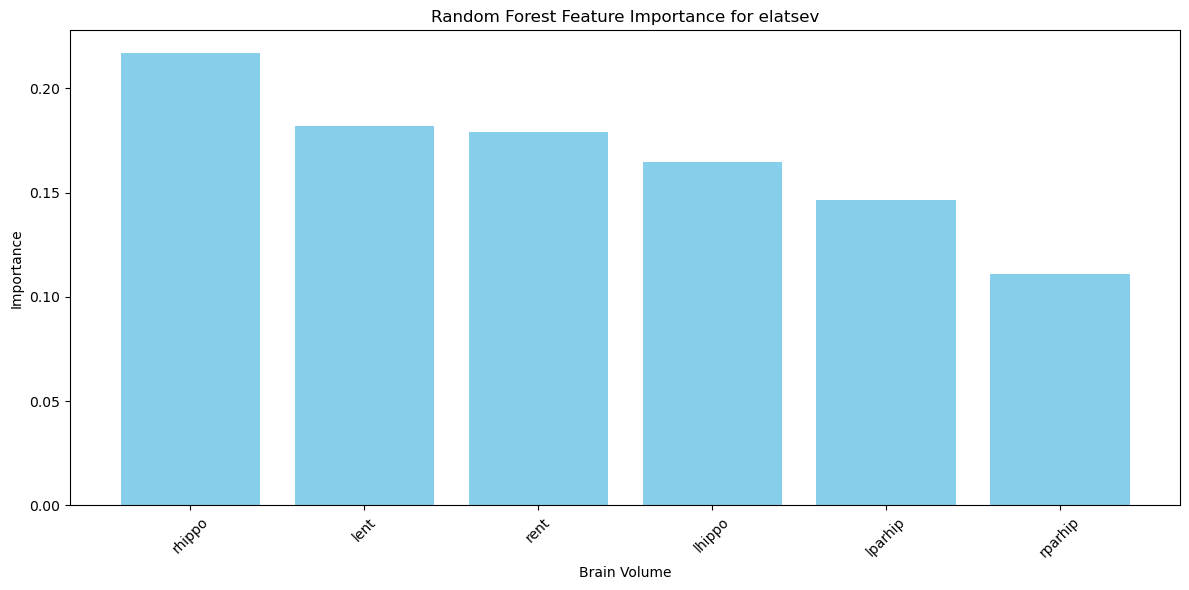

delsev — R²: -0.1220


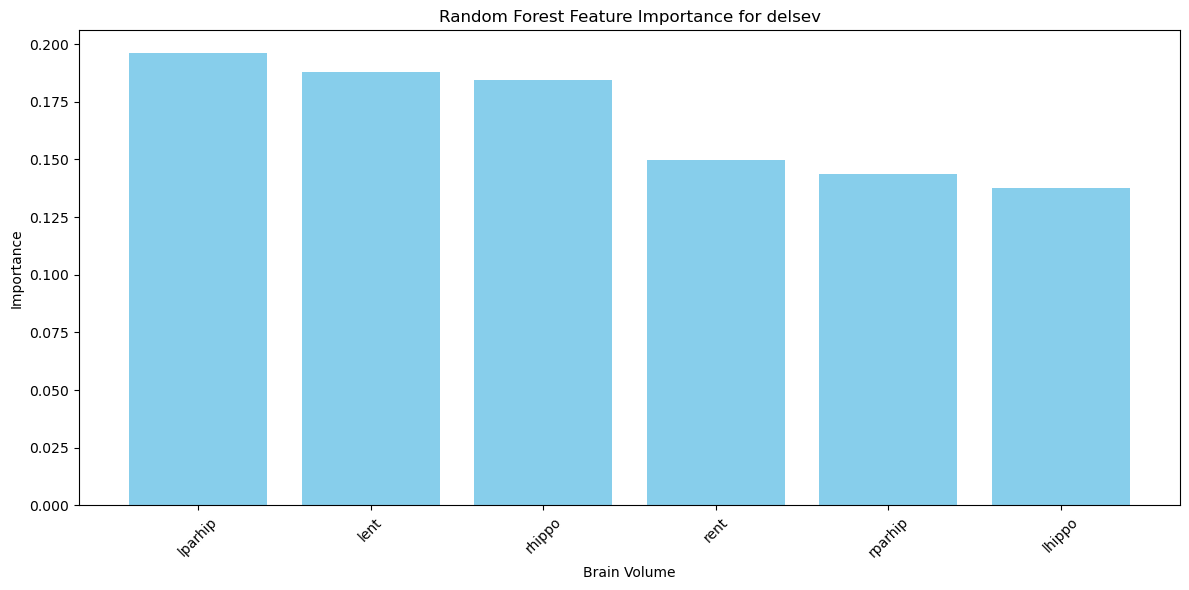

motsev — R²: -0.1092


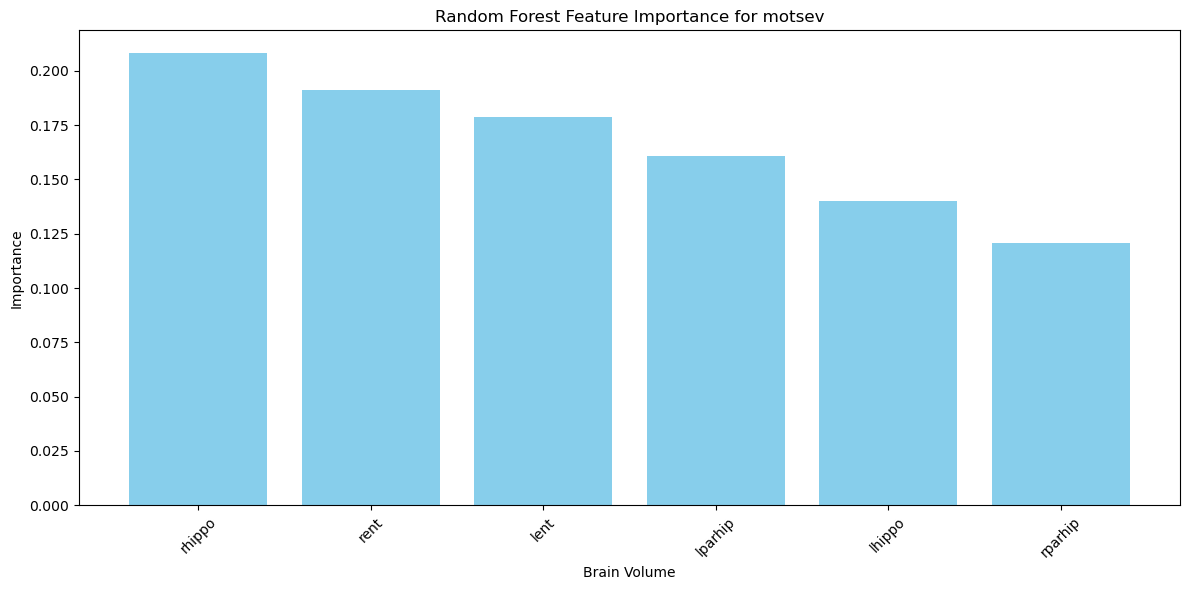

In [10]:
# Top 3 predictions
top_3_rf = sorted(rf_results, key=lambda x: abs(x["r2"]), reverse=True)[:3]

for res in top_3_rf:
    sev = res["severity_index"]
    r2 = res["r2"]

    print(f"{sev} — R²: {r2:.4f}")

    plot_feature_importance(
        res["feature_importances"],
        target=sev,
        model_name="Random Forest", 
        show=True
    )


## Modeling comparison

In [11]:
comparison_df = compare_models(lr_results, rf_results)
comparison_df.to_csv(os.path.join(tables_dir, "model_comparison.csv"), index=False)
comparison_df


,severity_index,r2_lr,r2_rf,abs_diff
0,irrsev,0.009610,-0.010667,0.020276
1,apasev,0.024305,-0.028945,0.053250
2,nitesev,-0.005469,-0.035169,0.029700
3,agitsev,0.019270,-0.042546,0.061817
4,depdsev,-0.007467,-0.048333,0.040866
5,disnsev,0.009796,-0.048679,0.058476
6,anxsev,-0.032370,-0.050167,0.017797
7,hallsev,-0.019560,-0.080538,0.060979
8,appsev,0.003357,-0.097142,0.100499
9,motsev,0.001692,-0.109230,0.110921


## Conclusion

- All severity indices show **R² values near or below zero** for both Linear Regression and Random Forest.
- No linear or nonlinear relationships emerge between brain‑volume features and symptom severity.
- Linear Regression performs **slightly less poorly**, but still provides **no meaningful predictive signal**.
- Random Forest systematically underperforms, indicating **overfitting and lack of informative structure** in the features.
- The overall pattern is consistent across all outcomes, with **no model capturing usable variance**.

**Brain volumes features alone do not contain predictive information for these severity indices.**